In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from acq import UCB, EI, PI, KG, find_next_batch, optimize_acqf
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('../')
sys.path.append("../GaussianProcess")
import GaussianProcess.kernel as kernel
from cigp import CIGP_withMean



## Define the objective function
This objective function represents a simple sum of sine functions. The goal is to demonstrate a basic mathematical function that exhibits periodic behavior with different frequencies. The input 'x' is the variable at which the sine functions are evaluated, and the result is the sum of sin(x) and sin(2x).

In [10]:
def objective_function(x):
    # Simple sum of sine functions for demonstration
    return torch.sin(x)+torch.sin(2*x)

## Initialize prior knowledge with 5 random points

In [11]:
input_dim = 1
num_initial_points = 5
train_x = torch.rand(num_initial_points, input_dim) * 10  # Random points in [0, 10] for each dimension
train_y = objective_function(train_x).reshape(-1,1)

# Initialize the surrogate model
This code initializes a surrogate model for Bayesian optimization. The surrogate model (CIGP_withMean) is equipped with a chosen kernel (ARDKernel) to capture the underlying patterns in the data.  The Adam optimizer is then set up to optimize the model's parameters during the training process. 

In [12]:
kernel1 = kernel.ARDKernel(1)
# kernel1 = kernel.MaternKernel(1)
# kernel1 = kernel.LinearKernel(1,-1.0,1.)
# kernel1 = kernel.SumKernel(kernel.LinearKernel(1), kernel.MaternKernel(1))
model = CIGP_withMean(1, 1, kernel=kernel1, noise_variance=2.)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-2)

# Define the mean and variance functions for acq function
The defined mean and variance functions extract the predictive mean and variance from the trained surrogate model (model) when provided with input points (X). These functions are crucial components in the computation of acquisition functions, such as the Upper Confidence Bound (UCB), and are used to guide the selection of the next point for evaluation in the Bayesian optimization process.

In [13]:
def mean_function(X):
    model.eval()
    with torch.no_grad():
        mean, _ = model.forward(train_x, train_y, X)
        return mean

def variance_function(X):
    model.eval()
    with torch.no_grad():
        _, var = model.forward(train_x, train_y, X)
        return var

# Initialize acq function
The code snippet initializes different acquisition functions for Bayesian optimization.

In [14]:
ucb = UCB(mean_function, variance_function, kappa=5)
pi = PI(mean_function, variance_function)
ei = EI(mean_function, variance_function)
kg = KG(mean_function, variance_function, num_fantasies=10)
best_y = []
# use it to remember the key iteration
key_iterations = [2,4,5,6,8,10]
predictions = []
iteration_label = True


# Bayesian optimization loop
The key iterations allow monitoring the model's behavior and predictions at specific points during the optimization process. The overall process aims to iteratively improve the surrogate model and select points for evaluation that are expected to yield the best objective values.

In [15]:
# Bayesian optimization loop
bounds = torch.tensor([[0, 10]] * input_dim)
for iteration in range(10):  # Run for 5 iterations

    for i in range(100):
        optimizer.zero_grad()
        loss = -model.log_likelihood(train_x, train_y)
        loss.backward()
        optimizer.step()
        print('iter', i, 'nll:{:.5f}'.format(loss.item()))


    #batch_points = find_next_batch(ucb, bounds, batch_size=1, n_samples=500, f_best=train_x[np.argmax(train_y)])
    # batch_points = ei.find_next_batch(bounds, batch_size=1, n_samples=1000, f_best=train_x[np.argmax(train_y)])
    #find_next_batch(acq)
    batch_points = optimize_acqf(acq=ucb, q=1, raw_samples=50, bounds=bounds, f_best=0, num_restarts=30, options=None, return_best_only=False)
    batch_points = torch.tensor(batch_points).float()

    # Evaluate the objective function
    new_y = objective_function(batch_points.squeeze()).reshape(-1,1)

    # Update the model
    train_x = torch.cat([train_x, batch_points])
    train_y = torch.cat([train_y, new_y])
    # Store the best objective value found so far
    best_y.append(new_y.max().item())
    # Visualization

    # 在关键迭代时保存模型预测
    if (iteration + 1) in key_iterations:
        model.eval()
        fixed_dims = torch.full((1, input_dim - 1), 5.0)  # Example: set them to the midpoint (5.0)
        test_points = torch.linspace(0, 10, 100)
        test_X = torch.cat((test_points.unsqueeze(1), fixed_dims.expand(test_points.size(0), -1)), 1)
        true_y = objective_function(test_X)

        with torch.no_grad():
            pred_mean, pred_std = model.forward(train_x, train_y, test_X)
            predictions.append((pred_mean, pred_std))


iter 0 nll:8.65192
iter 1 nll:8.58240
iter 2 nll:8.51209
iter 3 nll:8.44099
iter 4 nll:8.36910
iter 5 nll:8.29641
iter 6 nll:8.22293
iter 7 nll:8.14867
iter 8 nll:8.07365
iter 9 nll:7.99790
iter 10 nll:7.92146
iter 11 nll:7.84437
iter 12 nll:7.76669
iter 13 nll:7.68851
iter 14 nll:7.60992
iter 15 nll:7.53101
iter 16 nll:7.45193
iter 17 nll:7.37280
iter 18 nll:7.29380
iter 19 nll:7.21509
iter 20 nll:7.13688
iter 21 nll:7.05942
iter 22 nll:6.98299
iter 23 nll:6.90797
iter 24 nll:6.83481
iter 25 nll:6.76402
iter 26 nll:6.69625
iter 27 nll:6.63220
iter 28 nll:6.57274
iter 29 nll:6.51888
iter 30 nll:6.47186
iter 31 nll:6.43862
iter 32 nll:6.47630
iter 33 nll:6.50588
iter 34 nll:6.52761
iter 35 nll:6.54128
iter 36 nll:6.54688
iter 37 nll:6.54497
iter 38 nll:6.53669
iter 39 nll:6.52373
iter 40 nll:6.50799
iter 41 nll:6.49133
iter 42 nll:6.47538
iter 43 nll:6.46130
iter 44 nll:6.44981
iter 45 nll:6.44116
iter 46 nll:6.43523
iter 47 nll:6.43163
iter 48 nll:6.42986
iter 49 nll:6.42941
iter 50 nl

C:\Users\24779\AppData\Local\Temp\ipykernel_24928\3894418734.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_points = torch.tensor(batch_points).float()


iter 32 nll:7.69872
iter 33 nll:7.69583
iter 34 nll:7.69372
iter 35 nll:7.69345
iter 36 nll:7.69403
iter 37 nll:7.69378
iter 38 nll:7.69216
iter 39 nll:7.69011
iter 40 nll:7.68890
iter 41 nll:7.68871
iter 42 nll:7.68859
iter 43 nll:7.68765
iter 44 nll:7.68610
iter 45 nll:7.68479
iter 46 nll:7.68420
iter 47 nll:7.68390
iter 48 nll:7.68318
iter 49 nll:7.68196
iter 50 nll:7.68077
iter 51 nll:7.68003
iter 52 nll:7.67953
iter 53 nll:7.67880
iter 54 nll:7.67774
iter 55 nll:7.67669
iter 56 nll:7.67593
iter 57 nll:7.67533
iter 58 nll:7.67457
iter 59 nll:7.67360
iter 60 nll:7.67267
iter 61 nll:7.67193
iter 62 nll:7.67125
iter 63 nll:7.67045
iter 64 nll:7.66953
iter 65 nll:7.66868
iter 66 nll:7.66795
iter 67 nll:7.66722
iter 68 nll:7.66639
iter 69 nll:7.66553
iter 70 nll:7.66475
iter 71 nll:7.66402
iter 72 nll:7.66325
iter 73 nll:7.66243
iter 74 nll:7.66163
iter 75 nll:7.66088
iter 76 nll:7.66014
iter 77 nll:7.65936
iter 78 nll:7.65857
iter 79 nll:7.65781
iter 80 nll:7.65708
iter 81 nll:7.65632


# plot the picture
This visualization helps to understand how well the Gaussian Process model captures the true function and how uncertainty evolves as more samples are acquired during the optimization process.

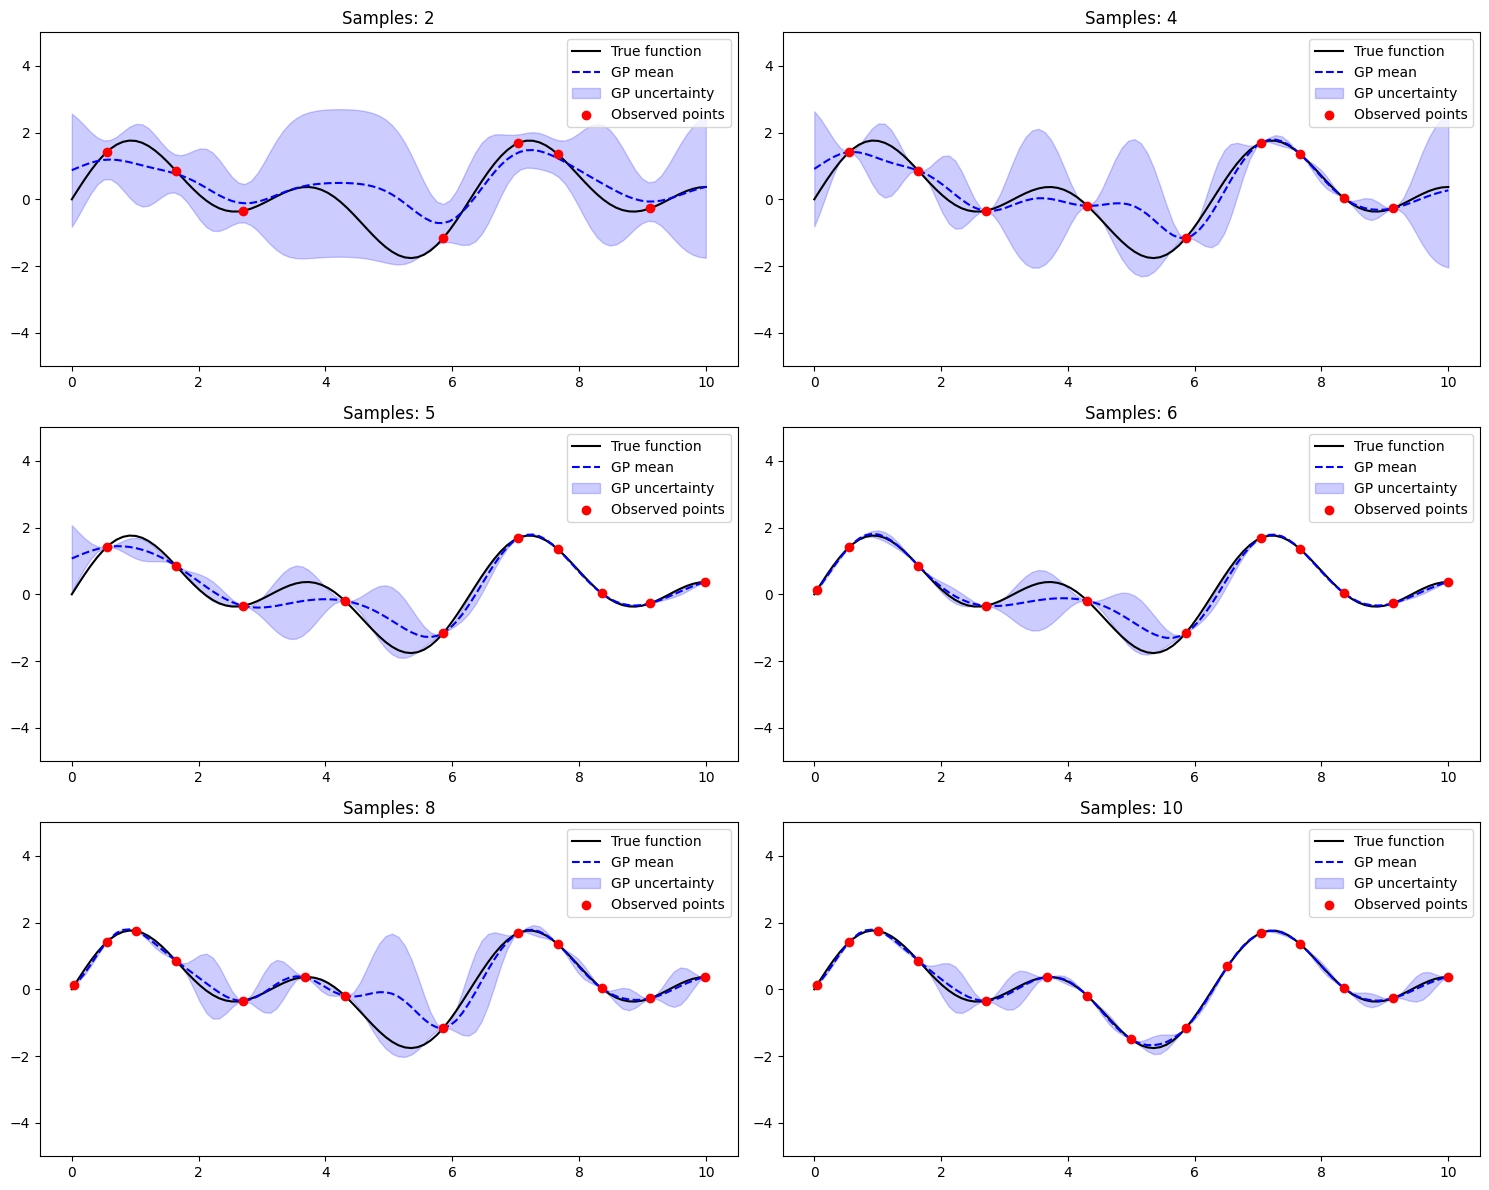

In [16]:
# 绘制子图
plt.figure(figsize=(15, 12))
for i, (pred_mean, pred_std) in enumerate(predictions):
    plt.subplot(3, 2, i+1)
    plt.ylim(-5, 5)
    plt.plot(test_points.numpy(), true_y.numpy(), 'k-', label='True function')
    plt.plot(test_points.numpy(), pred_mean.numpy(), 'b--', label='GP mean')
    plt.fill_between(test_points.numpy().reshape(-1),
                     (pred_mean - 2 * pred_std).numpy().reshape(-1),
                     (pred_mean + 2 * pred_std).numpy().reshape(-1),
                     color='blue', alpha=0.2, label='GP uncertainty')

    observed_x = train_x[:, 0].numpy()  # Only the first dimension for all observed points
    observed_y = train_y.numpy()
    plt.scatter(observed_x[:num_initial_points+key_iterations[i]], observed_y[:num_initial_points+key_iterations[i]], c='r', zorder=3, label='Observed points')
    plt.title(f'Samples: {key_iterations[i]}')
    plt.legend()

plt.tight_layout()
plt.show()
